In this code, I want to test how LeNet perform as a multi tasking model: classifier and denoiser. The architecture for classifier is the original Lenet. For the denoising, I created another part for upsampling and recontruct the original image.

Input: image with added noise

Output: class of image and denoised image.

In [ ]:
import torch
import torchvision
import numpy as np

###########################
#Define hyperparameters
batch_size = 32
num_epochs = 20
learning_rate = 0.001
noise = 0.1

###########################
# Functions to generate noise
def generate_random_zero_filter(img, noise_factor):       #generate a filter with random zeros
    filter = (torch.rand(size=(img.shape)) > noise_factor).int()
    return filter

#########################
# transform the image data type to a 32x32 matrix of numbers
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(0, 1),
                                            torchvision.transforms.Resize((32,32))])

#########################
# Load data
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)



############################
# Define network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class classification_denoising(nn.Module):
    def __init__(self):
        super(classification_denoising, self).__init__()
        #Encoder is LeNet without fc layers
        self.en_conv1 = nn.Conv2d(1, 6, 5)
        self.en_conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)

        #Output for classification
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        #Decoder for denoising
        self.de_convt1 = nn.ConvTranspose2d(16, 8, 7, stride=7)
        self.de_convt2 = nn.ConvTranspose2d(8, 4, 1)
        self.out = nn.Conv2d(4, 1, 4)

    def forward(self, x):
        #Encode
        x = F.relu(self.en_conv1(x))
        x = self.pool(x)
        x = F.relu(self.en_conv2(x))
        x = self.pool(x)

        # Classification
        h1 = torch.flatten(x, 1)
        h1 = F.relu(self.fc1(h1))
        h1 = F.relu(self.fc2(h1))
        h1 = self.fc3(h1)

        #Decode
        h2 = F.relu(self.de_convt1(x))
        h2 = F.relu(self.de_convt2(h2))
        h2 = torch.sigmoid(self.out(h2))

        

        return h1, h2

model = classification_denoising()
print(model)

# Define loss function and optimizer
mse_loss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
############################
# Train model       #Unconmment this to train the network again
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         images, label = data
#         images = np.clip(images, 0., 1.)
#         img_noisy = images * generate_random_zero_filter(images, noise)
#         img_noisy = np.clip(img_noisy, 0., 1.)
#         optimizer.zero_grad()
#         classification, denoising = model(img_noisy)
#         loss1 = ce_loss(classification, label)
#         loss2 = mse_loss(denoising, images)
#         total_loss = loss1 + loss2
#         total_loss.backward()
#         optimizer.step()
#         running_loss += total_loss.item()
#         if i % 200 == 199:  # print every 200 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 1000))
#             running_loss = 0.0
# print("Finish training")
# Save model
# torch.save(net.state_dict(), 'multitask_model.pth')

Load model
net = denoising_and_classification()
net.load_state_dict(torch.load('multitask_model.pth'))
net.eval()

classification_denoising(
  (en_conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (en_conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_convt1): ConvTranspose2d(16, 8, kernel_size=(7, 7), stride=(7, 7))
  (de_convt2): ConvTranspose2d(8, 4, kernel_size=(1, 1), stride=(1, 1))
  (out): Conv2d(4, 1, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
[1,   200] loss: 0.196
[1,   400] loss: 0.063
[1,   600] loss: 0.046
[1,   800] loss: 0.041
[1,  1000] loss: 0.037
[1,  1200] loss: 0.034
[1,  1400] loss: 0.030
[1,  1600] loss: 0.030
[1,  1800] loss: 0.030
[2,   200] loss: 0.028
[2,   400] loss: 0.026
[2,   600] loss: 0.025
[2,   800] loss: 0.025
[2,  1000] loss: 0.023
[2,  1200] loss: 0.022
[2,  1400] loss: 0.022
[2,  1600

#####
Prediction: tensor(2)
Ground truth: tensor(2)


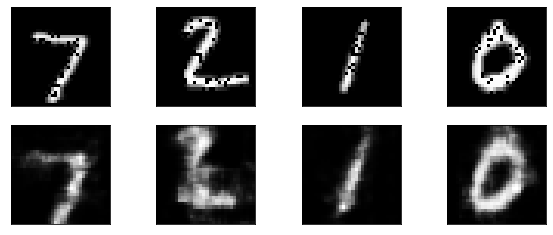

In [ ]:
#functions to save image
from torchvision.utils import save_image
import os
def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)


##########################
# Test the trained network
for i, data in enumerate(testloader, 0):
    images, label = data
    img_noisy = images * generate_random_zero_filter(images, noise)
    img_noisy = np.clip(img_noisy, 0., 1.)
    classification, denoising = model(img_noisy)
    save_image(img_noisy, 'noisy_test_input.png')
    save_image(denoising, 'denoised_test_reconstruction.png')
    print('#####')
    print('Prediction: ' + str(torch.argmax(classification[1])))
    print('Ground truth: ' + str(label[1]))
    # plt.imshow()
    break

# add noise to the test images
noisy_imgs = images * generate_random_zero_filter(images, 0.2)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
classification, denoising = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of images
denoising = denoising.view(batch_size, 1, 32, 32)

# use detach when it's an output that requires_grad
denoising = denoising.detach().numpy()

# plot the first 4 input images and then denoised images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(10,4))

# input images on top row, denoising on bottom
for noisy_imgs, row in zip([noisy_imgs, denoising], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()
